In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sea
import random
import scipy.stats as stats
import xgboost
from collections import defaultdict
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import SCORERS
import warnings; warnings.simplefilter('ignore')

#importing data
data = pd.read_csv('movies_metadata.csv')

#data cleaning
#dropping some data
data.drop(['belongs_to_collection', 'homepage', 'original_title', 'overview' ,'tagline', 'status', 'video', 'id', 'imdb_id'],axis=1,inplace=True)
data.dropna(inplace=True)

#convert and remove datatype to numerical, remove empty values.
data['budget'] = data['budget'].astype(np.float)
data['popularity'] = data['popularity'].astype(np.float)
data = data[~(data == 0).any(axis=1)]
#data['loggross'] = np.log1p(data['revenue'])
#data['revenuemillions'] = data['revenue']/1000000

#data processing, reformatted some attributes
data['genres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_companies'] = data['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_countries'] = data['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['spoken_languages'] = data['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

#replace link with poster number
data['poster_path'].fillna(0, inplace=True)
data.loc[data['poster_path'] != 0, 'poster_path'] = 1

#remove [] from data points for converting
data['genres'] = data['genres'].map(lambda x: str(x)[:-1])
data['genres'] = data['genres'].map(lambda x: str(x)[1:])

data['production_countries'] = data['production_countries'].map(lambda x: str(x)[:-1])
data['production_countries'] = data['production_countries'].map(lambda x: str(x)[1:])

data['spoken_languages'] = data['spoken_languages'].map(lambda x: str(x)[:-1])
data['spoken_languages'] = data['spoken_languages'].map(lambda x: str(x)[1:])

data['production_companies'] = data['production_companies'].map(lambda x: str(x)[:-1])
data['production_companies'] = data['production_companies'].map(lambda x: str(x)[1:])

#reformat month-day-year to 4 attributes day, weekday, month, year
data['release_date'] = pd.to_datetime(data['release_date'], infer_datetime_format=True)
data['day'] = data['release_date'].apply(lambda t: t.day)
data['weekday'] = data['release_date'].apply(lambda t: t.weekday())
data['month'] = data['release_date'].apply(lambda t: t.month)
data['year'] = data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)

#from visualization, budget and popularity correlate with each other so mapping budget to vote count could improve prediction

a = defaultdict()
data['budget'] = data['budget'].fillna(0)
temp = data[data['budget'] != 0]
vote_count_mean = pd.Series(temp.groupby(['vote_count'])['budget'].agg('mean'))
a = dict(vote_count_mean)
for i in data[data['budget'] == 0]:
        data['budget'] = data.loc[:, 'vote_count'].map(a)

#data.budget.describe()

#convert attributes to binary and remove them to dataset
genres= data.genres.str.get_dummies(sep=',')
data =pd.concat([data,genres],axis=1)
data.drop(['genres'],axis=1,inplace=True)

country = data.production_countries.str.get_dummies(sep=',')
data =pd.concat([data,country],axis=1)
data.drop(['production_countries'],axis=1,inplace=True)

company = data.production_companies.str.get_dummies(sep=',')
data =pd.concat([data,company],axis=1)
data.drop(['production_companies'],axis=1,inplace=True)

language = pd.get_dummies(data['original_language'])
data = pd.concat([data, language], axis=1)      
data.drop(['original_language'], inplace=True, axis=1)

#drop the unnecessary columns 
data.drop(['adult', 'release_date', 'spoken_languages', 'title'],axis=1,inplace=True)

#data.dtypes
#data.head()

#processed database
database = data.drop(['revenue'],axis=1)
target = data['revenue']

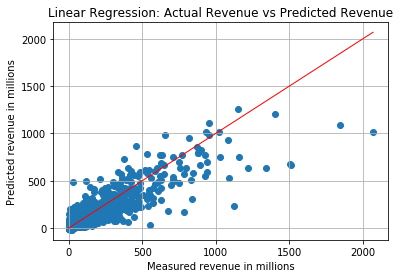

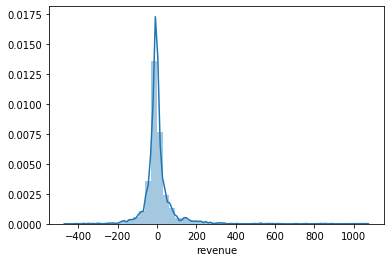

Mean Absolute Error: 40.89143306545995
Mean Squared Error: 7013.954479745299
Median Absolute Error: 18.800637428754587
Explained Var Score: 0.7745421259089321
R^2 Score: 0.7740972094911824
Root Mean Squared Error: 83.74935510047405
Root Mean Squared Logarithmic Error: 1.0610982252359695


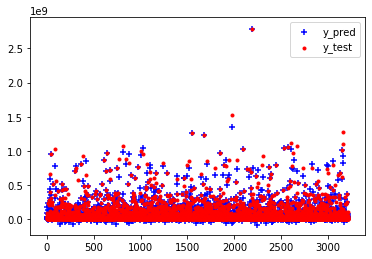

In [2]:
#LinearRegressorModel

LinearRegressorModel = LinearRegression()
train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.4, random_state = 0)
LinearRegressorModel.fit(train_data,train_target)
prediction = LinearRegressorModel.predict(test_data)

def rmsle(train_target, prediction):
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(prediction) - np.log1p(train_target), 2))), False
LinearRegressorModel = LGBMRegressor(boosting_type='dart',num_leaves=20,max_depth=-1,min_data_in_leaf=20, learning_rate=0.2,n_estimators=500,subsample_for_bin=200000,class_weight=None,min_split_gain=0.0,min_child_weight=0.001,subsample=0.1,subsample_freq=0,colsample_bytree=0.75,reg_alpha=0.0,reg_lambda=0.0,random_state=101,n_jobs=-1)
LinearRegressorModel.fit(train_data, train_target,eval_set=[(test_data, test_target)],eval_metric=rmsle,verbose=False)
prediction = LinearRegressorModel.predict(test_data, num_iteration=LinearRegressorModel.best_iteration_)

fig, ax = plt.subplots()
test_target = test_target/1000000
prediction = prediction/1000000
ax.scatter(test_target, prediction)
ax.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], lw=1, color = 'r')
ax.set_xlabel('Measured revenue in millions')
ax.set_ylabel('Predicted revenue in millions')
plt.title("Linear Regression: Actual Revenue vs Predicted Revenue" )
plt.grid()
plt.show()

sea.distplot((test_target-prediction),bins=50)
plt.show()

lr = LinearRegression()
lr.fit(train_data, train_target)
lr.score(test_data, test_target)
y_pred2 = lr.predict(train_data)
y = range(y_pred2.shape[0])

plt.scatter(y, y_pred2, c='b', marker='+')
plt.scatter(y, train_target, c='r', marker='.')
labels = ['y_pred', 'y_test']
plt.legend(labels)

print('Mean Absolute Error:', metrics.mean_absolute_error(test_target, prediction))
print('Mean Squared Error:', metrics.mean_squared_error(test_target, prediction))
print('Median Absolute Error:', metrics.median_absolute_error(test_target, prediction))
print('Explained Var Score:', metrics.explained_variance_score(test_target, prediction))
print('R^2 Score:', metrics.r2_score(test_target, prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_target, prediction)))
print('Root Mean Squared Logarithmic Error:', np.sqrt(np.mean(np.power(np.log1p(prediction) - np.log1p(test_target), 2))))


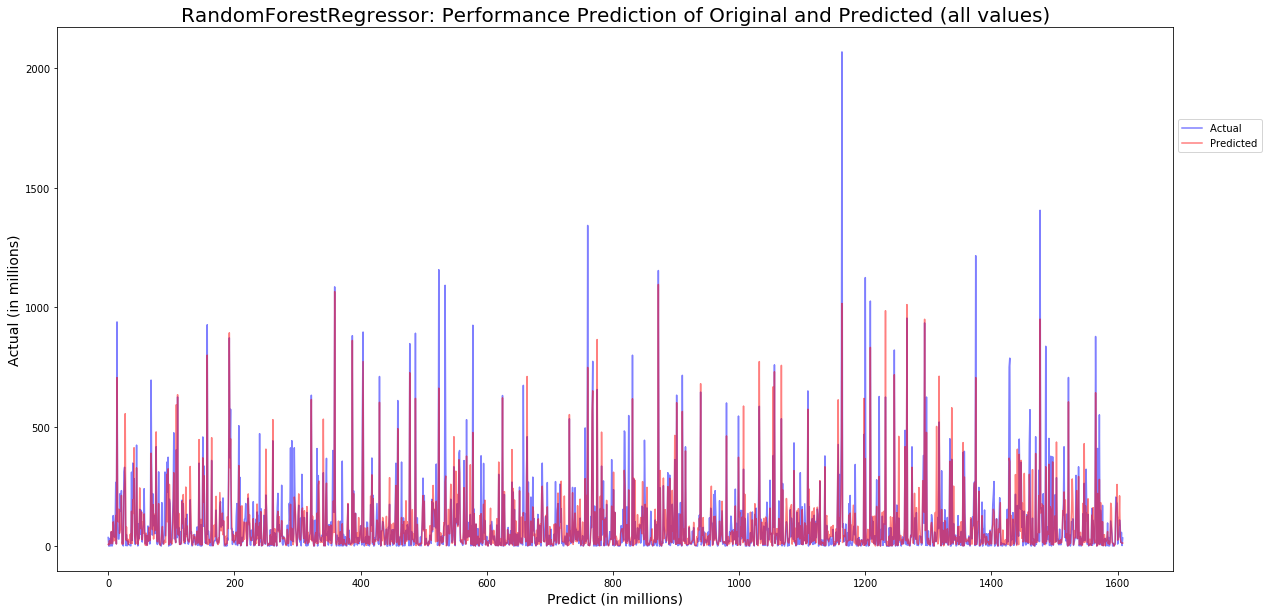

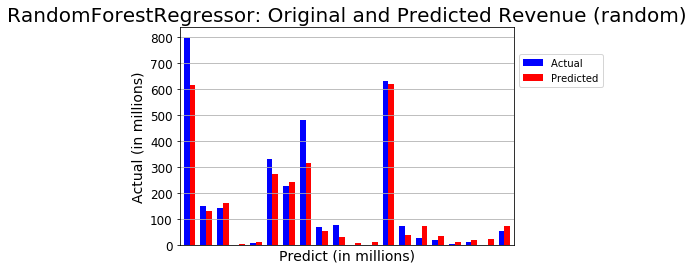

Regression Scores(train_test_split):

Mean Absolute Error    : 43.0860583004972
Mean Squared Error     : 7318.583824768555
Median Absolute Error  : 18.17833209999999
Explained Var Score    : 0.7604143383350634
R^2 Score              : 0.7591310386974575


In [3]:
#randomForestRegressorModel

randomForestRegressorModel = RandomForestRegressor()
train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.3, random_state = 0) 
randomForestRegressorModel.fit(train_data, train_target)
prediction = randomForestRegressorModel.predict(test_data)

original = np.asarray(test_target)

#print(original)
#print(prediction)
original = original/1000000
prediction = prediction/1000000

plt.figure(figsize=(20,10))
plt.title('RandomForestRegressor: Performance Prediction of Original and Predicted (all values)',fontsize = 20)
plt.plot(original, c = 'blue', alpha = 0.5)
plt.plot(prediction, c = 'red', alpha = 0.5)
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.show()

original_list = []
predicted_list = []
for k in range(20):
    i = random.randint(0, len(prediction) - 1)
    original_list.append(original[i])
    predicted_list.append(prediction[i])
    
original_data = pd.DataFrame(original_list)
predicted_data = pd.DataFrame(predicted_list)
    
actual_vs_predicted = pd.concat([original_data, predicted_data], axis = 1)
    
actual_vs_predicted.plot(kind = "bar", fontsize = 12, color = ['b','r'], width= 0.7)
plt.title('RandomForestRegressor: Original and Predicted Revenue (random)',fontsize = 20)
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.xticks([])
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.grid()
plt.show()

mean_abs_error = mean_absolute_error(original, prediction) 
mean_sqr_error = mean_squared_error(original, prediction)
median_abs_error = median_absolute_error(original, prediction)
explained_var_score = explained_variance_score(original, prediction)
r2__score = r2_score(original, prediction)
print("Regression Scores(train_test_split):\n")
print("Mean Absolute Error    :", mean_abs_error)
print("Mean Squared Error     :", mean_sqr_error)
print("Median Absolute Error  :", median_abs_error)
print("Explained Var Score    :", explained_var_score)
print("R^2 Score              :", r2__score)


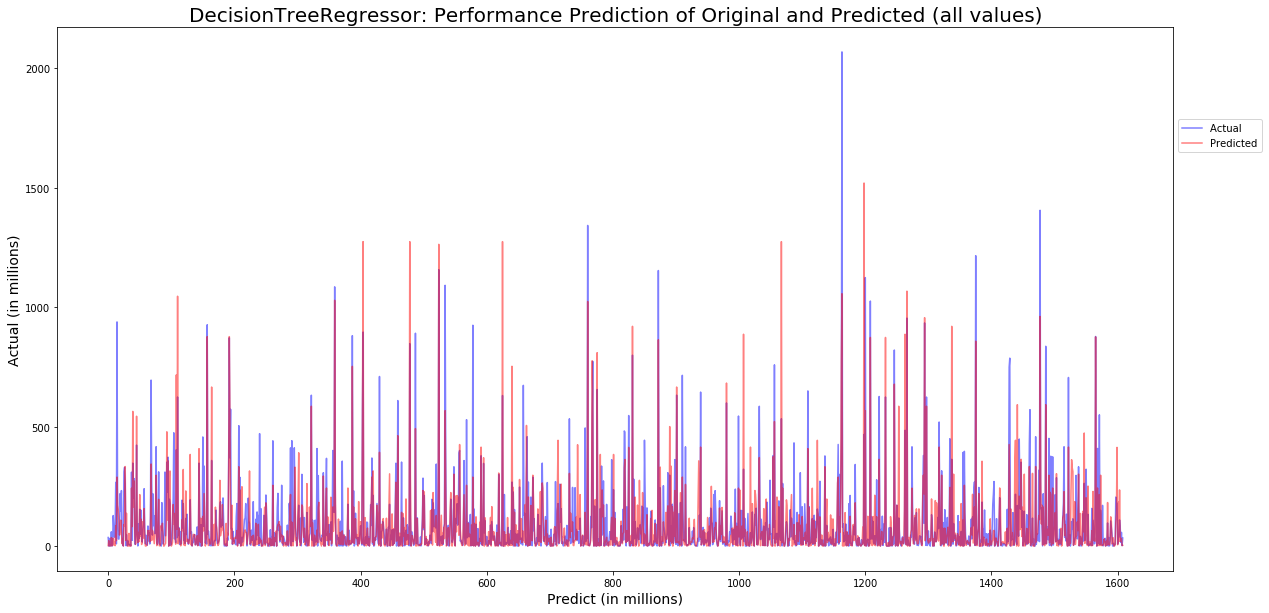

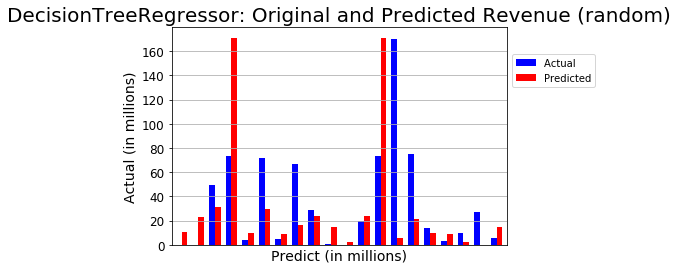

Regression Scores(train_test_split):

Mean Absolute Error    : 56.02417574518334
Mean Squared Error     : 11869.96062760985
Median Absolute Error  : 22.0
Explained Var Score    : 0.6114912440340521
R^2 Score              : 0.6093362929863173


In [4]:
#DecisionTreeRegressorModel

DecisionTreeRegressorModel = tree.DecisionTreeRegressor()
train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.3, random_state = 0) 
DecisionTreeRegressorModel.fit(train_data, train_target)
prediction = DecisionTreeRegressorModel.predict(test_data)

original = np.asarray(test_target)

#print(original)
#print(prediction)
original = original/1000000
prediction = prediction/1000000

plt.figure(figsize=(20,10))
plt.title('DecisionTreeRegressor: Performance Prediction of Original and Predicted (all values)',fontsize = 20)
plt.plot(original, c = 'blue', alpha = 0.5)
plt.plot(prediction, c = 'red', alpha = 0.5)
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.show()

original_list = []
predicted_list = []
for k in range(20):
    i = random.randint(0, len(prediction) - 1)
    original_list.append(original[i])
    predicted_list.append(prediction[i])
    
original_data = pd.DataFrame(original_list)
predicted_data = pd.DataFrame(predicted_list)
    
actual_vs_predicted = pd.concat([original_data, predicted_data], axis = 1)
    
actual_vs_predicted.plot(kind = "bar", fontsize = 12, color = ['b','r'], width= 0.7)
plt.title('DecisionTreeRegressor: Original and Predicted Revenue (random)',fontsize = 20)
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.xticks([])
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.grid()
plt.show()

mean_abs_error = mean_absolute_error(original, prediction) 
mean_sqr_error = mean_squared_error(original, prediction)
median_abs_error = median_absolute_error(original, prediction)
explained_var_score = explained_variance_score(original, prediction)
r2__score = r2_score(original, prediction)
print("Regression Scores(train_test_split):\n")
print("Mean Absolute Error    :", mean_abs_error)
print("Mean Squared Error     :", mean_sqr_error)
print("Median Absolute Error  :", median_abs_error)
print("Explained Var Score    :", explained_var_score)
print("R^2 Score              :", r2__score)